# Figure 5: Average rank obtained per augmentation and dataset.

[:simple-jupyter: :material-download:](../../paper_tables_and_figures/figure5_augmentations_comparison_across_datasets_average_rank/figure5_augmentations_comparison_across_datasets_average_rank.ipynb)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import autorank
import pandas as pd

In [3]:
dat = {
    "mirage19": pd.read_parquet(
        "./campaigns/mirage19/augmentation-at-loading-no-dropout/minpkts10/campaign_summary/1684958367/runsinfo_flowpic_dim_32.parquet"
    ),
    "mirage22_10": pd.read_parquet(
        "./campaigns/mirage22/augmentation-at-loading-no-dropout/minpkts10/campaign_summary/1684958367/runsinfo_flowpic_dim_32.parquet"
    ),
    "mirage22_1000": pd.read_parquet(
        "./campaigns/mirage22/augmentation-at-loading-no-dropout/minpkts1000/campaign_summary/1684958367/runsinfo_flowpic_dim_32.parquet"
    ),
    "utmobile19": pd.read_parquet(
        "./campaigns/utmobilenet21/augmentation-at-loading-no-dropout/minpkts10/campaign_summary/1684958367/runsinfo_flowpic_dim_32.parquet"
    ),
}

In [10]:
def prepare_data(df):
    res = df[["hash", "aug_name", "seed", "split_index", "f1"]]
    res.loc[:, "id"] = (
        "split_index"
        + res.loc[:, "split_index"].astype(str)
        + "_seed"
        + res.loc[:, "seed"].astype(str)
    )
    res = res[["aug_name", "id", "f1"]]
    return res.sort_values(["aug_name", "id"])


def get_ranks(df):
    df1 = prepare_data(df)
    df1 = df1.pivot(columns="aug_name", index="id").reset_index(drop=True)
    df1.columns = df1.columns.get_level_values(1)
    new_df = pd.DataFrame(
        {
            "changertt": df1["changertt"].values,
            "colorjitter": df1["colorjitter"].values,
            "horizontalflip": df1["horizontalflip"].values,
            "noaug": df1["noaug"].values,
            "packetloss": df1["packetloss"].values,
            "rotate": df1["rotate"].values,
            "timeshift": df1["timeshift"].values,
        }
    )
    replacement = {
        "noaug": "No augmentation",
        "horizontalflip": "Horizontal flip",
        "rotate": "Rotate",
        "timeshift": "Time shift",
        "colorjitter": "Color jitter",
        "changertt": "Change RTT",
        "packetloss": "Packet Loss",
    }
    new_df = new_df.rename(columns=replacement).dropna()
    rankmat = new_df.rank(axis="columns", ascending=False)
    return rankmat

In [12]:
def prepare_ranks_data(dataset):
    res = get_ranks(dat[dataset])
    res["dataset"] = dataset
    return res


together = pd.concat(
    [
        prepare_ranks_data("mirage19"),
        prepare_ranks_data("mirage22_10"),
        prepare_ranks_data("mirage22_1000"),
        prepare_ranks_data("utmobile19"),
    ]
)

df_tmp = pd.melt(
    together, id_vars=["dataset"], var_name="augmentation", value_name="rank"
)

/tmp/ipykernel_54500/2978918141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:, "id"] = (
/tmp/ipykernel_54500/2978918141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:, "id"] = (
/tmp/ipykernel_54500/2978918141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [13]:
df_tmp2 = df_tmp.groupby(["dataset", "augmentation"])["rank"].mean().reset_index()

In [14]:
df_tmp2.head()

,dataset,augmentation,rank
0,mirage19,Change RTT,1.0
1,mirage19,Color jitter,5.2
2,mirage19,Horizontal flip,3.0
3,mirage19,No augmentation,4.0
4,mirage19,Packet Loss,5.3


<Axes: xlabel='dataset', ylabel='augmentation'>

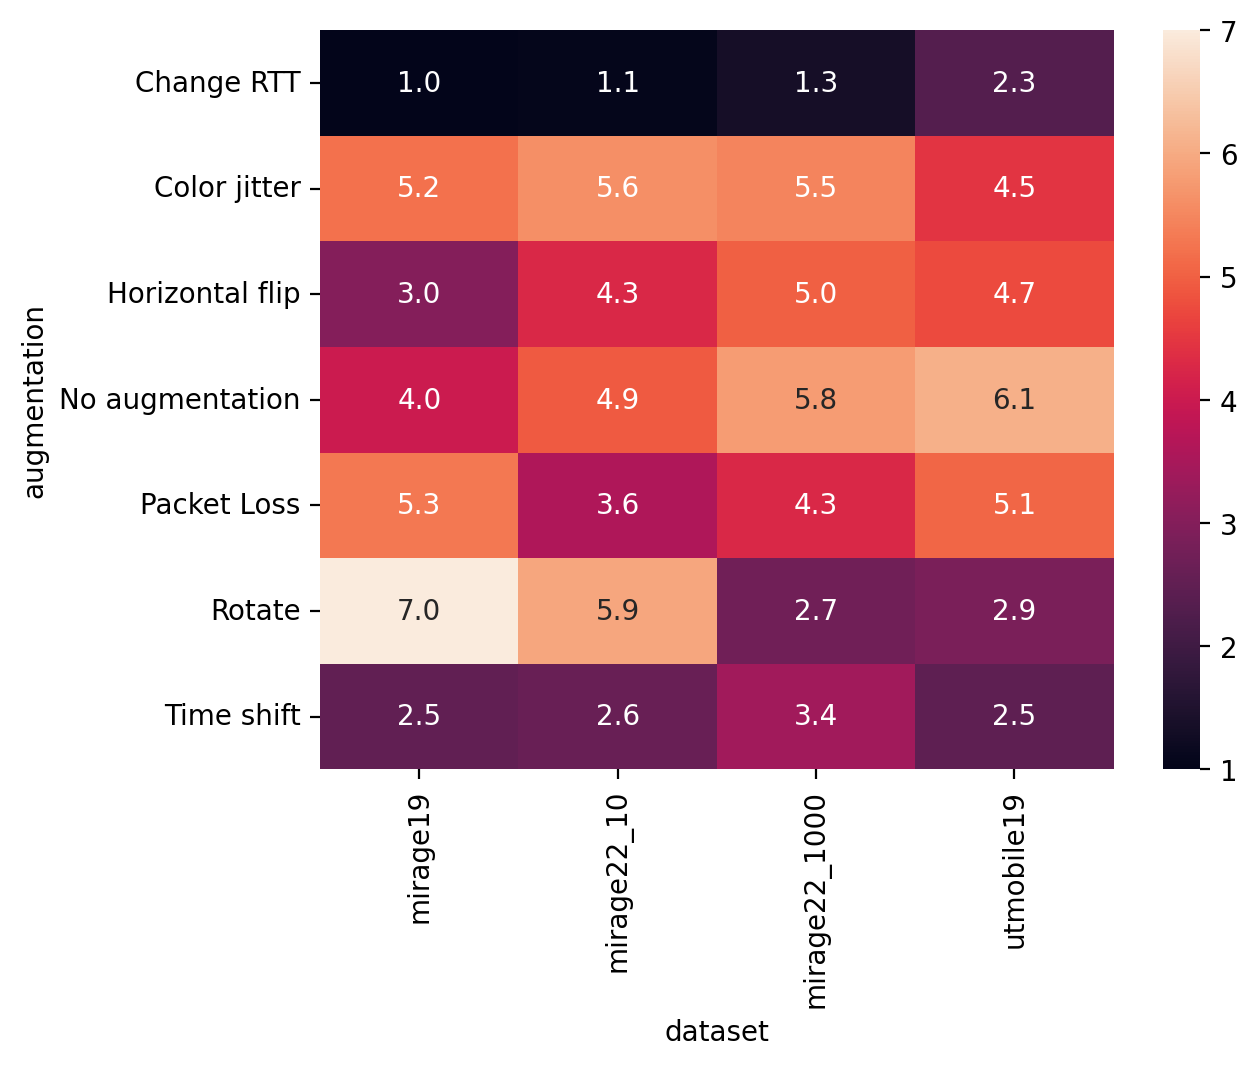

In [15]:
sns.heatmap(
    data=df_tmp2.pivot(index="augmentation", columns="dataset", values="rank"),
    annot=True,
    fmt=".1f",
)